In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import OneHotEncoder
import torch
import kagglehub

In [20]:
# Read in csv file
df = pd.read_csv(r"insurance.csv")

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


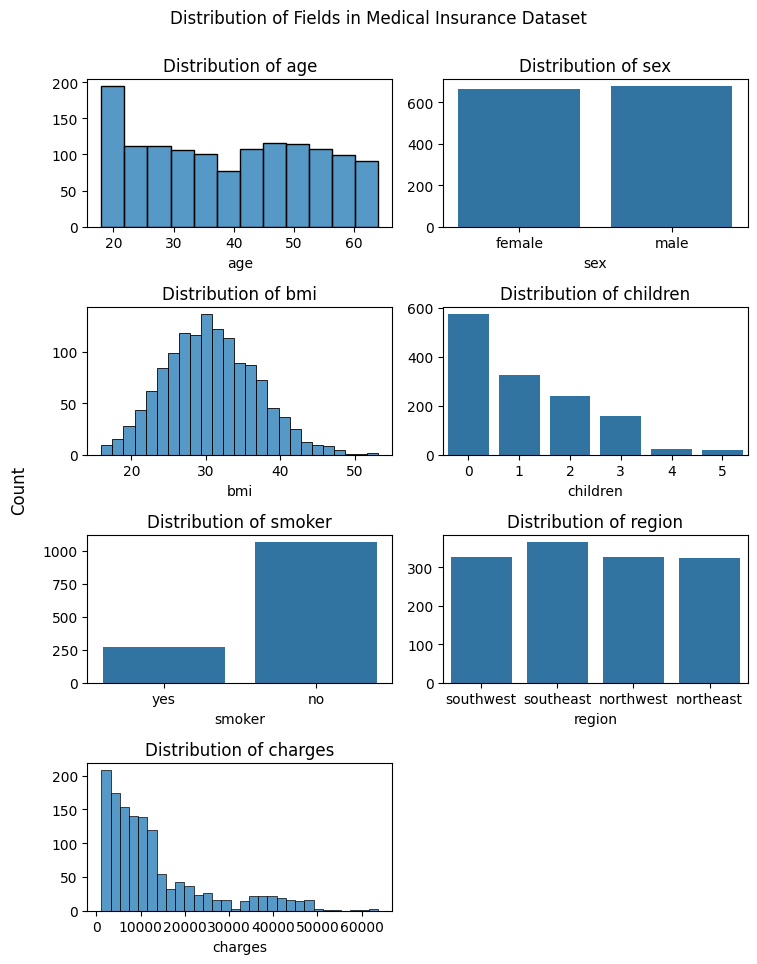

In [21]:
# First we do some EDA and see the distribution of the data

fig1, axes1 = plt.subplots(math.ceil(len(df.columns)/2),2)

# Remove extra plot for odd number of columns
if len(df.columns)%2 == 1:
    fig1.delaxes(axes1[-1,-1])

fig1.suptitle("Distribution of Fields in Medical Insurance Dataset", y=1)
fig1.supylabel("Count")

for i, field in enumerate(df.columns):

    # Histplot for wider range numerical values
    if field in ["age", "bmi", "charges"]:
        sns.histplot(x = field, data = df, ax = axes1[i//2,i%2])
    # Countplot for categorical data or numerical with only a few values
    else:
        sns.countplot(x = field, data = df, ax = axes1[i//2,i%2])

    axes1[i//2,i%2].set_title(f"Distribution of {field}")
    axes1[i//2,i%2].set_ylabel("")

fig1.set_figheight(fig1.get_figheight()*2)
fig1.set_figwidth(fig1.get_figwidth()*1.2)
fig1.tight_layout()
plt.show()

As from the plots above, we can see there is an uneven distribution of data for smokers

In [ ]:
df["smoker"] = df["smoker"].apply(lambda x: x == "yes")
df["sex"] = df["sex"].apply(lambda x: x == "female")

# One-Hot encode the region variable
df = pd.get_dummies(df, columns = ["region"])

In [23]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,True,27.900,0,True,16884.92400,False,False,False,True
1,18,False,33.770,1,False,1725.55230,False,False,True,False
2,28,False,33.000,3,False,4449.46200,False,False,True,False
3,33,False,22.705,0,False,21984.47061,False,True,False,False
4,32,False,28.880,0,False,3866.85520,False,True,False,False
